In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import cv2
import tensorflow as tf
import keras
# from keras import backend as K
from keras import backend
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
# import foolbox
import PIL
import numpy as np
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

import cleverhans
from cleverhans.attacks import SaliencyMapMethod, FastGradientMethod, BasicIterativeMethod, DeepFool, CarliniWagnerL2
# from cleverhans.utils import other_classes, set_log_level
# from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
# from cleverhans.utils_mnist import data_mnist
# from cleverhans.utils_tf import model_train, model_eval, model_argmax
from cleverhans.utils_keras import KerasModelWrapper
# from cleverhans_tutorials.tutorial_models import make_basic_cnn

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
# import tensorflow as tf
# with tf.device('/gpu:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)

# with tf.Session() as sess:
#     print (sess.run(c))

In [2]:
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

image_height = 224
image_width = 224

In [3]:
model = VGGFace()

In [4]:
def get_Face(imagePath):
    # Read the image
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )
    faces = faceCascade.detectMultiScale(gray, 1.2, 5)
    
    im = PIL.Image.open(imagePath)

    (x, y, w, h) = faces[0]

    center_x = x+w//2
    center_y = y+h//2
    b_dim = min(max(w,h)*1.2,im.width, im.height) # WARNING : this formula in incorrect
    #box = (x, y, x+w, y+h)
    box = (center_x-b_dim/2, center_y-b_dim/2, center_x+b_dim/2, center_y+b_dim/2)
    # Crop Image
    crpim = im.crop(box).resize((224,224))
    
    return crpim

In [5]:
def preprocess_input(x, data_format=None, version=1):
    x_temp = np.copy(x)
    if data_format is None:
        data_format = backend.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}
    
#     print('version: ', version, 'data_format', data_format)
    if version == 1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7624
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863

    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError

    return x_temp

In [6]:
def load_image(img):
#     img = image.load_img(img, target_size=(image_height, image_width))
#     img = image.load_img(get_Face(img), target_size=(image_height, image_width))
    img = get_Face(img)
#     plt.imshow(img)
    x = image.img_to_array(img)
#     print(x)
    x = np.expand_dims(x, axis=0)
#     x = utils.preprocess_input(x, version=1) # or version=2
    x = preprocess_input(x, version=1) # or version=2
    
    return x

In [7]:
# x_val = load_image('Aamir_Khan.jpg')
# x_val = load_image('ak.png')
# x_val = load_image('faces/Wayne_Knight/Wayne_Knight4.jpg')
x_val = load_image('faces/Adam_Copeland/adam-copeland.jpg')
# x_val[:]
# np.savez("x_images_arrays", x_val)
# np.savetxt('adam.csv', x_val)

In [8]:
def deproc(x, data_format=None, version=1):
    
    x_temp = np.copy(x)
    if data_format is None:
        data_format = backend.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}
    
    if version == 1:
        if data_format == 'channels_first':
            x_temp[:, 0, :, :] += 93.5940
            x_temp[:, 1, :, :] += 104.7624
            x_temp[:, 2, :, :] += 129.1863
            x_temp = x_temp[:, ::-1, ...]
        else:
            x_temp[..., 0] += 93.5940
            x_temp[..., 1] += 104.7624
            x_temp[..., 2] += 129.1863
            x_temp = x_temp[..., ::-1]

    elif version == 2:
        if data_format == 'channels_first':
            x_temp[:, 0, :, :] += 91.4953
            x_temp[:, 1, :, :] += 103.8827
            x_temp[:, 2, :, :] += 131.0912
            x_temp = x_temp[:, ::-1, ...]
        else:
            x_temp[..., 0] += 91.4953
            x_temp[..., 1] += 103.8827
            x_temp[..., 2] += 131.0912
            x_temp = x_temp[..., ::-1]
    else:
        raise NotImplementedError


    return x_temp

[[[ 28.  27.  22.]
  [ 28.  27.  22.]
  [ 28.  27.  22.]
  ...
  [ 22.  21.  16.]
  [ 23.  22.  17.]
  [ 23.  22.  17.]]

 [[ 28.  27.  22.]
  [ 28.  27.  22.]
  [ 28.  27.  22.]
  ...
  [ 22.  21.  16.]
  [ 23.  22.  17.]
  [ 23.  22.  17.]]

 [[ 29.  28.  23.]
  [ 29.  28.  23.]
  [ 29.  28.  23.]
  ...
  [ 22.  21.  16.]
  [ 22.  21.  16.]
  [ 22.  21.  16.]]

 ...

 [[ 84.  81.  74.]
  [ 84.  81.  74.]
  [ 69.  66.  59.]
  ...
  [138. 134. 125.]
  [ 41.  37.  28.]
  [ 41.  37.  28.]]

 [[ 46.  43.  36.]
  [ 46.  43.  36.]
  [ 17.  14.   7.]
  ...
  [171. 167. 158.]
  [ 63.  59.  50.]
  [ 63.  59.  50.]]

 [[ 46.  43.  36.]
  [ 46.  43.  36.]
  [ 17.  14.   7.]
  ...
  [171. 167. 158.]
  [ 63.  59.  50.]
  [ 63.  59.  50.]]]


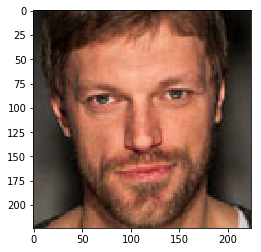

In [9]:
# plt.imshow(image.array_to_img(deproc(x_val).reshape(image_height, image_width, 3)))
# np.set_printoptions(threshold=np.nan)
print(deproc(x_val).reshape(image_height, image_width, 3))
plt.imshow(image.array_to_img(deproc(x_val).reshape(image_height, image_width, 3)))

In [10]:
x_val.shape

(1, 224, 224, 3)

In [11]:
preds = model.predict(x_val)
y_val = preds.argmax(axis=-1)[0]
print('Predicted:', utils.decode_predictions(preds))
y_val


Predicted: [[["b'Adam_Copeland'", 0.93260753], ["b'Jesse_Spencer'", 0.008635119], ["b'Lucas_Bryant'", 0.006299899], ["b'Joel_Kinnaman'", 0.0035176538], ["b'Greg_Vaughan'", 0.0025361935]]]


17

In [20]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())


In [29]:
if not hasattr(backend, "tf"):
    raise RuntimeError("This tutorial requires keras to be configured"
                       " to use the TensorFlow backend.")

if keras.backend.image_dim_ordering() != 'tf':
    keras.backend.set_image_dim_ordering('tf')
    print("INFO: '~/.keras/keras.json' sets 'image_dim_ordering' to "
          "'th', temporarily setting to 'tf'")
    
# Retrieve the tensorflow session
# sess = backend.get_session()
# keras.backend.set_session(sess)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess = tf.Session(config=config) 
keras.backend.tensorflow_backend.set_session(sess)

In [34]:
# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, image_height, image_width, 3))
y = tf.placeholder(tf.float32, shape=(None, 2623)) # ? 2622
# y = tf.placeholder(tf.float32, shape=(None, 1000))

In [35]:
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)

# eps – (required float) maximum distortion of adversarial example compared to original input
# clip_min – (optional float) Minimum input component value
# clip_max – (optional float) Maximum input component value

fgsm_params = {'eps': .1,
               'clip_min': -100.,
               'clip_max': 100.}

adv_x = fgsm.generate_np(x_val, **fgsm_params)     
# adv_pred = np.argmax(model.predict(adv_x), axis = 1)[0]

adv_preds = model.predict(adv_x)
adv_y = adv_preds.argmax(axis=-1)[0]
print('Predicted:', utils.decode_predictions(adv_preds))
# print(adv_y)

# adv_pred = np.argmax(model.predict(adv_x), axis = 1)
adv_acc =  np.mean(np.equal(adv_y, y_val))

print("The adversarial validation accuracy is: {}".format(adv_acc))

plt.imshow(image.array_to_img(deproc(adv_x).reshape(image_height, image_width, 3)))
# plt.imshow(image.array_to_img(deproc(adv_x).reshape(image_height, image_width, 3) - deproc(x_val).reshape(image_height, image_width, 3)))

FailedPreconditionError: Attempting to use uninitialized value conv1_1/bias
	 [[Node: conv1_1/bias/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1_1/bias)]]
	 [[Node: model_7/flatten/Shape/_53 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_110_model_7/flatten/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'conv1_1/bias/read', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-abce0e0402bf>", line 1, in <module>
    model = VGGFace()
  File "/usr/local/lib/python3.6/dist-packages/keras_vggface/vggface.py", line 81, in VGGFace
    classes=classes)
  File "/usr/local/lib/python3.6/dist-packages/keras_vggface/models.py", line 46, in VGG16
    img_input)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py", line 590, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python3.6/dist-packages/keras/layers/convolutional.py", line 144, in build
    constraint=self.bias_constraint)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py", line 414, in add_weight
    constraint=constraint)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 392, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/variables.py", line 397, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py", line 142, in identity
    return gen_array_ops.identity(input, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 3187, in identity
    "Identity", input=input, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value conv1_1/bias
	 [[Node: conv1_1/bias/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1_1/bias)]]
	 [[Node: model_7/flatten/Shape/_53 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_110_model_7/flatten/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


Predicted: [[["b'Adam_Copeland'", 0.8548107], ["b'Jesse_Spencer'", 0.0105000865], ["b'Lucas_Bryant'", 0.00941883], ["b'Greg_Vaughan'", 0.0057878173], ["b'Joel_Kinnaman'", 0.005048383]]]
The adversarial validation accuracy is: 0.0


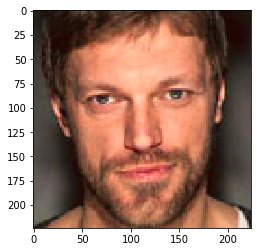

In [32]:
bim = BasicIterativeMethod(wrap, sess=sess)


# eps – (required float) maximum distortion of adversarial example compared to original input
# eps_iter – (required float) step size for each attack iteration
# nb_iter – (required int) Number of attack iterations.
# clip_min – (optional float) Minimum input component value
# clip_max – (optional float) Maximum input component value


bim_params = {'eps': .1,
               'clip_min': -100.,
               'eps_iter': .02,
               'clip_max': 100.,
               'nb_iter': 5}

# adv_x1 = bim.generate(x_val, **fgsm_params)
adv_x1 = bim.generate_np(x_val, **bim_params)
# Consider the attack to be constant
# adv_x1 = tf.stop_gradient(adv_x1)
# preds_adv1 = model(adv_x1)

# adv_pred1 = np.argmax(model.predict(adv_x1), axis = 1)

adv_preds1 = model.predict(adv_x1)
adv_y1 = adv_preds.argmax(axis=-1)[0]
print('Predicted:', utils.decode_predictions(adv_preds1))

adv_acc1 = np.mean(np.equal(adv_preds1, y_val))

print("The adversarial validation accuracy is: {}".format(adv_acc1))


plt.imshow(image.array_to_img(deproc(adv_x1).reshape(image_height, image_width, 3)))
# plt.imshow(image.array_to_img(deproc(adv_x1).reshape(image_height, image_width, 3) - deproc(x_val).reshape(image_height, image_width, 3)))

In [16]:
np.array_equal(adv_x, adv_x1)

False

In [17]:
jsma = SaliencyMapMethod(wrap, sess=sess)


# theta – (optional float) Perturbation introduced to modified components (can be positive or negative) 
# gamma – (optional float) Maximum percentage of perturbed features === eps
# clip_min – (optional float) Minimum component value for clipping
# clip_max – (optional float) Maximum component value for clipping


jsma_params = {'theta': 1.,
               'gamma': 1.,
               'clip_min': -100., 
               'clip_max': 100.,}

# adv_x1 = bim.generate(x_val, **fgsm_params)
adv_x2 = jsma.generate_np(x_val, **jsma_params)
# Consider the attack to be constant
# adv_x1 = tf.stop_gradient(adv_x1)
# preds_adv1 = model(adv_x1)

# adv_pred1 = np.argmax(model.predict(adv_x1), axis = 1)

adv_preds2 = model.predict(adv_x2)
adv_y2 = adv_preds.argmax(axis=-1)[0]
print('Predicted:', utils.decode_predictions(adv_preds2))

adv_acc2 =  np.mean(np.equal(adv_pred2, y_val))

print("The adversarial validation accuracy is: {}".format(adv_acc2))


plt.imshow(image.array_to_img(deproc(adv_x2).reshape(image_height, image_width, 3)))
# plt.imshow(image.array_to_img(deproc(adv_x2).reshape(image_height, image_width, 3) - deproc(x_val).reshape(image_height, image_width, 3)))

MemoryError: 

Predicted: [[["b'Joel_Kinnaman'", 0.20344408], ["b'Adam_Copeland'", 0.18748458], ["b'David_Lyons'", 0.075115904], ["b'Carmine_Giovinazzo'", 0.022414936], ["b'Jesse_Spencer'", 0.016764117]]]
The adversarial validation accuracy is: 0.0


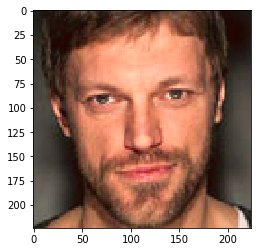

In [19]:
df = DeepFool(wrap, sess=sess)


# nb_candidate – The number of classes to test against, i.e., deepfool only consider nb_candidate classes when attacking(thus accelerate speed). The nb_candidate classes are chosen according to the prediction confidence during implementation.
# overshoot – A termination criterion to prevent vanishing updates
# max_iter – Maximum number of iteration for deepfool
# nb_classes – The number of model output classes
# clip_min – Minimum component value for clipping
# clip_max – Maximum component value for clipping


df_params = {'clip_min': -100.,
             'clip_max': 100.,}

# adv_x1 = bim.generate(x_val, **fgsm_params)
adv_x3 = df.generate_np(x_val, **df_params)
# Consider the attack to be constant
# adv_x1 = tf.stop_gradient(adv_x1)
# preds_adv1 = model(adv_x1)

# adv_pred1 = np.argmax(model.predict(adv_x1), axis = 1)

adv_preds3 = model.predict(adv_x3)
adv_y3 = adv_preds.argmax(axis=-1)[0]
print('Predicted:', utils.decode_predictions(adv_preds3))

adv_acc3 =  np.mean(np.equal(adv_preds3, y_val))

print("The adversarial validation accuracy is: {}".format(adv_acc3))


plt.imshow(image.array_to_img(deproc(adv_x3).reshape(image_height, image_width, 3)))
# plt.imshow(image.array_to_img(deproc(adv_x3).reshape(image_height, image_width, 3) - deproc(x_val).reshape(image_height, image_width, 3)))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Predicted: [[["b'Adam_Copeland'", 0.9032739], ["b'Lucas_Bryant'", 0.0077484353], ["b'Jesse_Spencer'", 0.007726416], ["b'Greg_Vaughan'", 0.00423654], ["b'Joel_Kinnaman'", 0.0035096135]]]
The adversarial validation accuracy is: 0.0


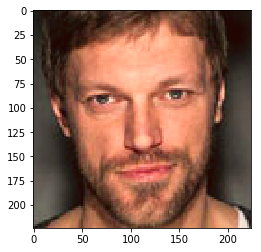

In [19]:
cw = CarliniWagnerL2(wrap, sess=sess)

# y – (optional) A tensor with the true labels for an untargeted attack. If None (and y_target is None) then use the original labels the classifier assigns.
# max_iterations – The maximum number of iterations. Setting this to a larger value will produce lower distortion results. Using only a few iterations requires a larger learning rate, and will produce larger distortion results.
# abort_early – If true, allows early aborts if gradient descent is unable to make progress (i.e., gets stuck in a local minimum).
# initial_const – The initial tradeoff-constant to use to tune the relative importance of size of the pururbation and confidence of classification. If binary_search_steps is large, the initial constant is not important. A smaller value of this constant gives lower distortion results.
# clip_min – (optional float) Minimum input component value
# clip_max – (optional float) Maximum input component value

cw_params = {'max_iterations': 3,
             'abort_early': 'true',
             'initial_const': 0.5,
             'clip_min': -100.,
             'clip_max': 100.,}

# adv_x1 = bim.generate(x_val, **fgsm_params)
adv_x4 = cw.generate_np(x_val, **cw_params)
# Consider the attack to be constant
# adv_x1 = tf.stop_gradient(adv_x1)
# preds_adv1 = model(adv_x1)

# adv_pred1 = np.argmax(model.predict(adv_x1), axis = 1)

adv_preds4 = model.predict(adv_x4)
adv_y4 = adv_preds.argmax(axis=-1)[0]
print('Predicted:', utils.decode_predictions(adv_preds4))

adv_acc4 =  np.mean(np.equal(adv_preds4, y_val))

print("The adversarial validation accuracy is: {}".format(adv_acc4))


plt.imshow(image.array_to_img(deproc(adv_x4).reshape(image_height, image_width, 3)))
# plt.imshow(image.array_to_img(deproc(adv_x4).reshape(image_height, image_width, 3) - deproc(x_val).reshape(image_height, image_width, 3)))

In [33]:
pics = [image.array_to_img(deproc(x_val).reshape(image_height, image_width, 3)),
       image.array_to_img(deproc(adv_x).reshape(image_height, image_width, 3) - deproc(x_val).reshape(image_height, image_width, 3)),
       image.array_to_img(deproc(adv_x).reshape(image_height, image_width, 3)),
       image.array_to_img(deproc(x_val).reshape(image_height, image_width, 3)),
       image.array_to_img(deproc(adv_x1).reshape(image_height, image_width, 3) - deproc(x_val).reshape(image_height, image_width, 3)),
       image.array_to_img(deproc(adv_x1).reshape(image_height, image_width, 3)),
       image.array_to_img(deproc(x_val).reshape(image_height, image_width, 3)),
       image.array_to_img(deproc(adv_x3).reshape(image_height, image_width, 3) - deproc(x_val).reshape(image_height, image_width, 3)),
       image.array_to_img(deproc(adv_x3).reshape(image_height, image_width, 3))]

# fig=plt.figure()
# # sub1 = plt.subplot(2, 2, 1)
# for i in range(3):
#     fig.add_subplot(1, 1, i+1)
#     plt.imshow(pics[i])
# plt.show()

In [21]:
# plt.imshow(np.clip(image.array_to_img(adv_x.reshape(image_height, image_width, 3))), )

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(pics[0])
axarr[0].set_title('Original')
axarr[0].set_ylabel('FGSM')
# axarr[0].axis('off')
axarr[1].imshow(pics[1])
axarr[1].set_title('Noise')
axarr[1].axis('off')
axarr[2].imshow(pics[2])
axarr[2].set_title('Adversarial')
axarr[2].axis('off')
# axarr[1,1].imshow(image_datas[3])

Text(0.5,0.965,'eps=.1, n=5, eps_iter=0.02')

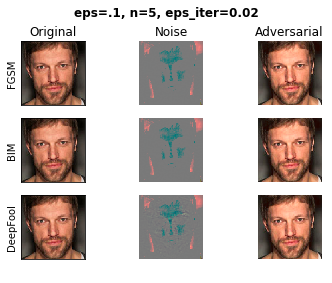

In [34]:
f, axarr = plt.subplots(3,3)

axarr[0, 0].imshow(pics[0])
axarr[0, 0].set_title('Original')
axarr[0, 0].set_ylabel('FGSM')
axarr[0, 0].axes.get_xaxis().set_visible(False)
axarr[0, 0].axes.get_yaxis().set_ticks([])
# axarr[0, 0].axis('off')
axarr[0, 1].imshow(pics[1])
axarr[0, 1].set_title('Noise')
axarr[0, 1].axis('off')
axarr[0, 2].imshow(pics[2])
axarr[0, 2].set_title('Adversarial')
axarr[0, 2].axis('off')

axarr[1, 0].imshow(pics[3])
axarr[1, 0].set_ylabel('BIM')
axarr[1, 0].axes.get_xaxis().set_visible(False)
axarr[1, 0].axes.get_yaxis().set_ticks([])
# axarr[1, 0].axis('off')
axarr[1, 1].imshow(pics[4])
axarr[1, 1].axis('off')
axarr[1, 2].imshow(pics[5])
axarr[1, 2].axis('off')

axarr[2, 0].imshow(pics[6])
axarr[2, 0].set_ylabel('DeepFool')
axarr[2, 0].axes.get_xaxis().set_visible(False)
axarr[2, 0].axes.get_yaxis().set_ticks([])
# axarr[2, 0].axis('off')
axarr[2, 1].imshow(pics[7])
axarr[2, 1].axis('off')
axarr[2, 2].imshow(pics[8])
axarr[2, 2].axis('off')

f.text(0.5, 0.965, 'eps=.1, n=5, eps_iter=0.02',
       horizontalalignment='center', color='black', weight='bold',
       size='large')


In [84]:
def get_validation(path):
    x = []
#     x = np.empty([108, 1])
    y = []
    for root, directories, filenames in os.walk('faces'):
    #     for directory in directories:
    #         print (os.path.join(root, directory))
        for filename in filenames: 
#             print (os.path.join(root,filename))
            try:
#                 immar = np.array(get_Face(os.path.join(root,filename)))
                immar = load_image(os.path.join(root,filename))
#                 immar = np.expand_dims(immar, axis=0)
                x.append(immar)
                y.append(root.split('/')[-1])
            except:
                pass
            
#     return np.array(x), np.array(y)
    return x, y

In [85]:
x1, y1 = get_validation('faces')

In [86]:
# (x1[0].shape)
x1

[array([[[[ 54.406     ,  69.2376    ,  58.813705  ],
          [ 28.405998  ,  43.237602  ,  32.813705  ],
          [ 22.405998  ,  38.237602  ,  27.813705  ],
          ...,
          [129.406     , 109.2376    ,  81.813705  ],
          [131.406     , 111.2376    ,  83.813705  ],
          [130.406     , 110.2376    ,  82.813705  ]],
 
         [[ 46.406     ,  61.237602  ,  50.813705  ],
          [ 23.405998  ,  38.237602  ,  27.813705  ],
          [ 20.405998  ,  36.237602  ,  25.813705  ],
          ...,
          [129.406     , 109.2376    ,  81.813705  ],
          [131.406     , 111.2376    ,  83.813705  ],
          [130.406     , 110.2376    ,  82.813705  ]],
 
         [[ 28.405998  ,  43.237602  ,  32.813705  ],
          [ 28.405998  ,  44.237602  ,  33.813705  ],
          [  0.40599823,  16.237602  ,   5.8137054 ],
          ...,
          [130.406     , 110.2376    ,  82.813705  ],
          [131.406     , 111.2376    ,  83.813705  ],
          [130.406     , 110.23

In [137]:
y11 = []
for i in x1:
    y11.append(utils.decode_predictions(model.predict(i))[0][0][0].split('\'')[1])

In [138]:
validation(y1, y11)

0.8666666666666667

In [54]:
# adv_y1 = adv_preds.argmax(axis=-1)[0]
print(utils.decode_predictions(model.predict(adv_x1))[0][0][0].split('\'')[1])

Aamir_Khan


In [60]:
def validation(y_true, y_val):
    k = 0
    for i in range(len(y_true)):
        if y_true[i] == y_val[i]:
            k += 1
            
    return k/len(y_val)

In [63]:
validation(y1, y11)
# len(y1)

105

In [123]:
Ybim = []
for i in x1:
#     y11.append(utils.decode_predictions(model.predict(q))[0][0][0].split('\'')[1])
    j = bim.generate_np(i, **bim_params)
    q = fgsm.generate_np(j, **fgsm_params)
#     q = bim.generate_np(q, **bim_params)
    Ybim.append(utils.decode_predictions(model.predict(q))[0][0][0].split('\'')[1])

In [124]:
validation(y1, Ybim)

0.8666666666666667

In [125]:
'hello'

'hello'